In [1]:
import potential as potlib
from gala.units import UnitSystem
from astropy import units as u
usys = UnitSystem(u.kpc, u.Myr, u.Msun, u.radian)
import jax.numpy as jnp

import diffrax
import fields as fields

import StreamSculptor
import potential
import matplotlib.pyplot as plt
import numpy as np

In [2]:
pot_NFW = potential.NFWPotential(m=1e12,r_s=20.0,units=usys)

In [3]:
pot_NFW.potential(jnp.array([1.0,2.0,3.0]),0.0)

Array(-0.20618832, dtype=float64)

In [4]:
ts = jnp.linspace(0,3000,3_000)
w0=jnp.array([20.,0.,20.,.0,.2,.0])
sol = pot_NFW.integrate_orbit(w0=w0, ts=ts,dense=True )



In [5]:
hamiltonian_field = fields.hamiltonian_field(pot_NFW)
hamiltonian_field.term(0.0,jnp.array([1.,2.,3.,.2,.3,.4]), None)

Array([ 0.2       ,  0.3       ,  0.4       , -0.00119364, -0.00238729,
       -0.00358093], dtype=float64)

In [6]:
kwargs = {'rtol':1e-6,'atol':1e-6,}


In [7]:
field_orb = fields.integrate_field(w0=w0, ts=ts,field=hamiltonian_field)
sol = pot_NFW.integrate_orbit(w0=w0, ts=ts,dense=False , **kwargs)


sol2 = pot_NFW.integrate_orbit(w0=w0+.01, ts=ts,dense=False , **kwargs)


In [8]:
sol2.ys

Array([[ 2.00100000e+01,  1.00000000e-02,  2.00100000e+01,
         1.00000000e-02,  2.10000000e-01,  1.00000000e-02],
       [ 2.00194156e+01,  2.20067674e-01,  2.00194156e+01,
         8.82506283e-03,  2.09993248e-01,  8.82506283e-03],
       [ 2.00276562e+01,  4.30122432e-01,  2.00276562e+01,
         7.65068504e-03,  2.09974182e-01,  7.65068504e-03],
       ...,
       [-2.77543980e+00, -2.64151490e+01, -2.77543980e+00,
         1.57129990e-01, -1.85143978e-02,  1.57129990e-01],
       [-2.61816847e+00, -2.64328064e+01, -2.61816847e+00,
         1.57306159e-01, -1.67882300e-02,  1.57306159e-01],
       [-2.46072597e+00, -2.64487357e+01, -2.46072597e+00,
         1.57472211e-01, -1.50592901e-02,  1.57472211e-01]],      dtype=float64)

In [9]:
sol.ys.sum()

Array(-2869.92203356, dtype=float64)

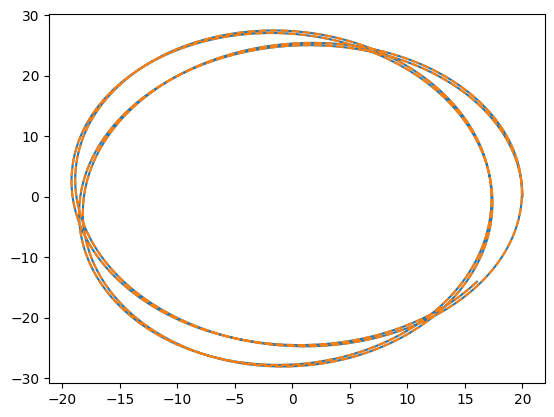

In [10]:
plt.plot(field_orb.ys[:,0], field_orb.ys[:,1])
plt.plot(sol.ys[:,0], sol.ys[:,1],ls='--')

In [11]:
kwargs = {'rtol':1e-8}




In [12]:
l, t = pot_NFW.gen_stream_scan(prog_w0=w0,ts=ts,Msat=1e4,seed_num=493, )

In [13]:
lv, tv = pot_NFW.gen_stream_vmapped(prog_w0=w0,ts=ts,Msat=1e4,seed_num=493, **kwargs)

In [14]:
lv.shape

(2999, 6)

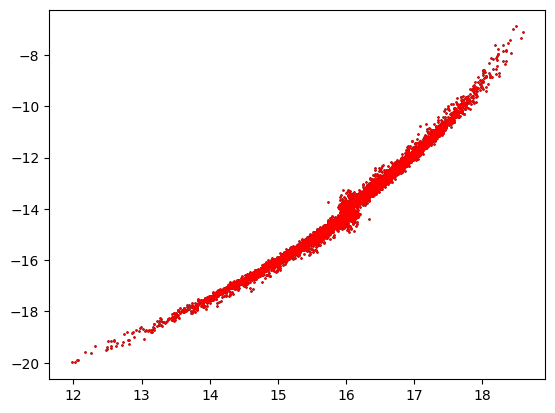

In [15]:
plt.scatter(l[:,0], l[:,1],s=0.5,color='k')
plt.scatter(t[:,0], t[:,1],s=0.5,color='k')

#plt.plot(sol.ys[:,0], sol.ys[:,1],ls='--')

plt.scatter(lv[:,0], lv[:,1],s=0.5,color='r')
plt.scatter(tv[:,0], tv[:,1],s=0.5,color='r')

In [18]:
ld_td = pot_NFW.gen_stream_scan_dense(prog_w0=w0,ts=ts,Msat=1e4,seed_num=493)

In [19]:
ld, td = StreamSculptor.eval_dense_stream(3000.0, ld_td)

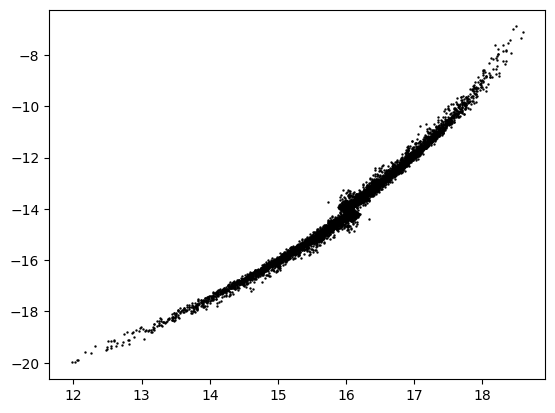

In [20]:
plt.scatter(ld[:,0], ld[:,1],s=0.5,color='k')
plt.scatter(td[:,0], td[:,1],s=0.5,color='k')


In [22]:
ldv_tdv = pot_NFW.gen_stream_vmapped_dense(prog_w0=w0,ts=ts,Msat=1e4,seed_num=493)

In [36]:
ldv, tdv = StreamSculptor.eval_dense_stream(3000.0, ldv_tdv)


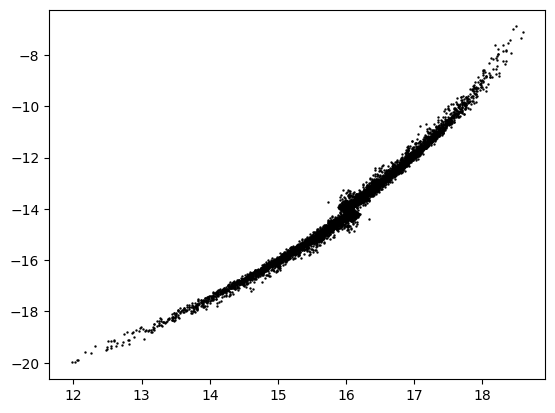

In [37]:
plt.scatter(ldv[:,0], ldv[:,1],s=0.5,color='k')
plt.scatter(tdv[:,0], tdv[:,1],s=0.5,color='k')


In [12]:
from perturbative import GenerateMassRadiusPerturbations

In [76]:
## Subhalo potential
N = 10
M = jnp.ones(N)
a = jnp.ones(N)
subhalo_x0 = jnp.array(np.random.normal(loc=0,scale=1,size=(N,3)))
subhalo_v = jnp.array(np.random.normal(loc=0,scale=1,size=(N,3)))
subhalo_t0 = jnp.ones(N)*0.0
t_window = jnp.ones(N)

pot_SH = potential.SubhaloLinePotential(m=M, a=a, subhalo_x0=subhalo_x0,
subhalo_v=subhalo_v, subhalo_t0=subhalo_t0, t_window=t_window,units=usys)
pot_structural = potential.SubhaloLinePotential_dRadius(m=M, a=a, subhalo_x0=subhalo_x0,
subhalo_v=subhalo_v, subhalo_t0=subhalo_t0, t_window=t_window,units=usys)

pot_structural.potential(jnp.array([1.,2,3.]),0.0)


Array(1.24796416e-12, dtype=float64)

In [81]:
pot_SH.potential_per_SH(jnp.array([2,3,4.]),-1000.0)

Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float64)

In [14]:
pert_Gen = GenerateMassRadiusPerturbations(potential_base=pot_NFW,potential_perturbation=pot_SH,
potential_structural=pot_structural, units=usys)

In [39]:
pert_Gen.gradientPotentialPerturbation_per_SH(jnp.array([1.,20.,3.]),0.0)

NameError: name 'pert_Gen' is not defined

In [21]:
from genstream import StreamModel
